<a href="https://colab.research.google.com/github/Karanam14/XGBoost.github.io/blob/main/Using_XGBoost_Data_Analysis_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sloan Digital Sky Survey Classification**

Classification of Galaxies, Stars and Quasars based on the RD14 from the SDSS
About the SDSS

The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested.


For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

**Data Acquisition:**

Public data from the SDSS can be accessed through multiple ways - I used the CasJobs website which offers a SQL-based interface which lets you query their database which contains the released data.


For more information about how to get data from the SDSS see their Data Access Guide:

http://www.sdss.org/dr14/data_access/

I used the sample query given by the CasJobs to receive the data. Find the exact query below:

Query:

SELECT TOP 10000

p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z, p.run, p.rerun, p.camcol, p.field,
s.specobjid, s.class, s.z as redshift, s.plate, s.mjd, s.fiberid
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE
p.u BETWEEN 0 AND 19.6
AND g BETWEEN 0 AND 20

The above query joins two tables (actually views): The image table (PhotoObj) which contains all image objects and the spectral table (SpecObj) which contains corresponding spectral data.

Feature Description:


View "PhotoObj"
objid = Object Identifier
ra = J2000 Right Ascension (r-band)
dec = J2000 Declination (r-band)

Right ascension (abbreviated RA) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated dec), these astronomical coordinates specify the direction of a point on the celestial sphere (traditionally called in English the skies or the sky) in the equatorial coordinate system.

Source: https://en.wikipedia.org/wiki/Right_ascension

u = better of DeV/Exp magnitude fit
g = better of DeV/Exp magnitude fit
r = better of DeV/Exp magnitude fit
i = better of DeV/Exp magnitude fit
z = better of DeV/Exp magnitude fit
The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further education: https://www.astro.umd.edu/~ssm/ASTR620/mags.html

run = Run Number

rereun = Rerun Number

camcol = Camera column

field = Field number

Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. A field can be identified by:

run number, which identifies the specific scan,
the camera column, or "camcol," a number from 1 to 6, identifying the scanline within the run, and
the field number. The field number typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
An additional number, rerun, specifies how the image was processed.
View "SpecObj"

specobjid = Object Identifier
class = object class (galaxy, star or quasar object)
The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.


redshift = Final Redshift

plate = plate number

mjd = MJD of observation

fiberid = fiber ID

In physics, redshift happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum.


Each spectroscopic exposure employs a large, thin, circular metal plate that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

Modified Julian Date, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.

The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding fiberID.

Further information on SDSS images and their attributes:

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Skyserver_SQL2_27_2018 6_51_39 PM.csv to Skyserver_SQL2_27_2018 6_51_39 PM.csv


In [3]:
sdss_df = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=0)

In [4]:
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [5]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


In [6]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


In [7]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [8]:
sdss_df.columns.values

array(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun',
       'camcol', 'field', 'specobjid', 'class', 'redshift', 'plate',
       'mjd', 'fiberid'], dtype=object)

In [9]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


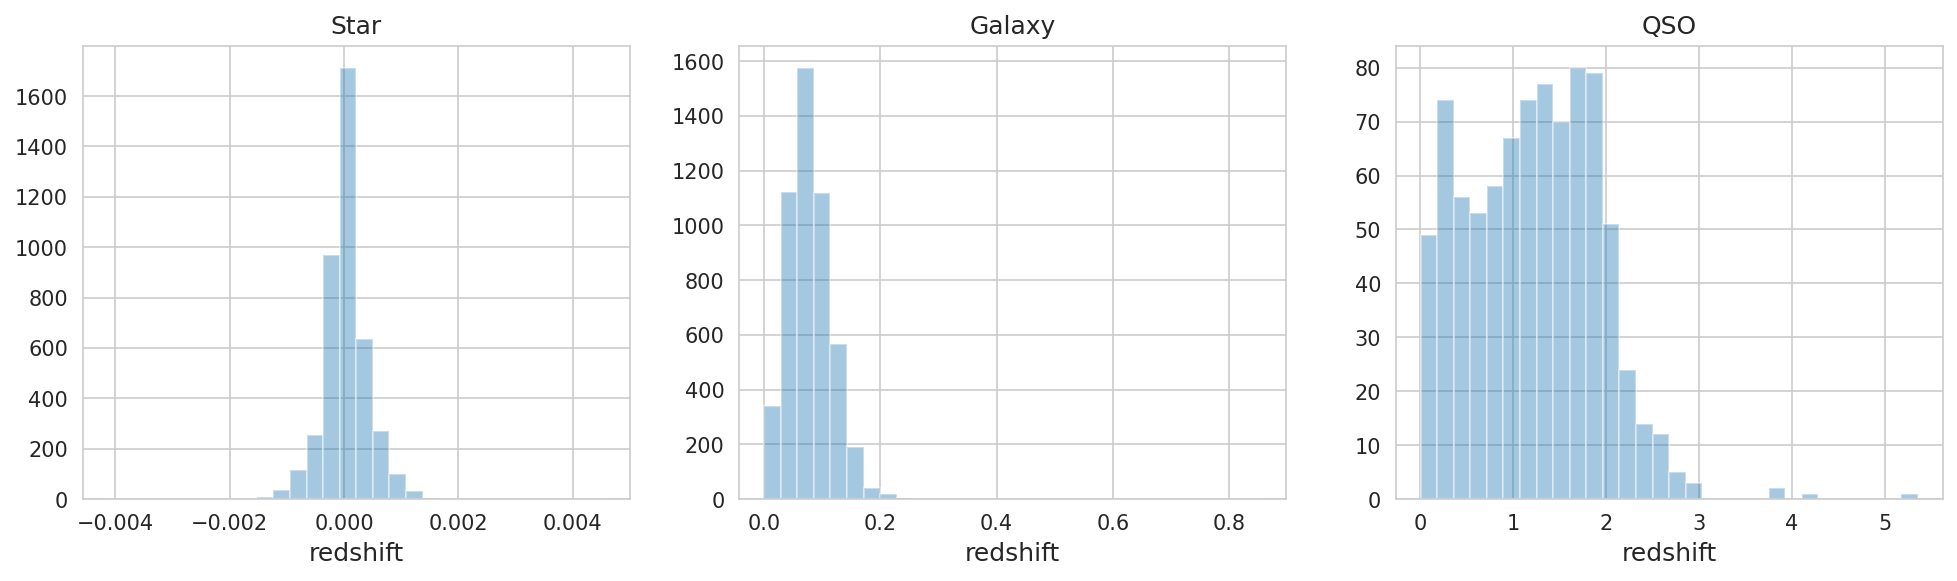

In [10]:
#Univariate Analysis
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

This is an interesting result.

We can cleary tell that the redshift values for the classes quite differ.

**Star**: The histogram looks like a truncated zero-centered normal distribution.

**Galaxy**: The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075.

**QSO**: The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers.

The redshift can be an estimate(!) for the distance from the earth to a object in space.

Hence the distplot tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far.

Possible rookie explanation: Since galaxies and quasars radiate stronger due to their size and physical structure, they can be observed from further away than "small" stars.

As we can distinct the classes from each other just based on this column - 'redshift' is very likely to be helping a lot classifying new objects.

Text(0.5, 1.0, 'dec')

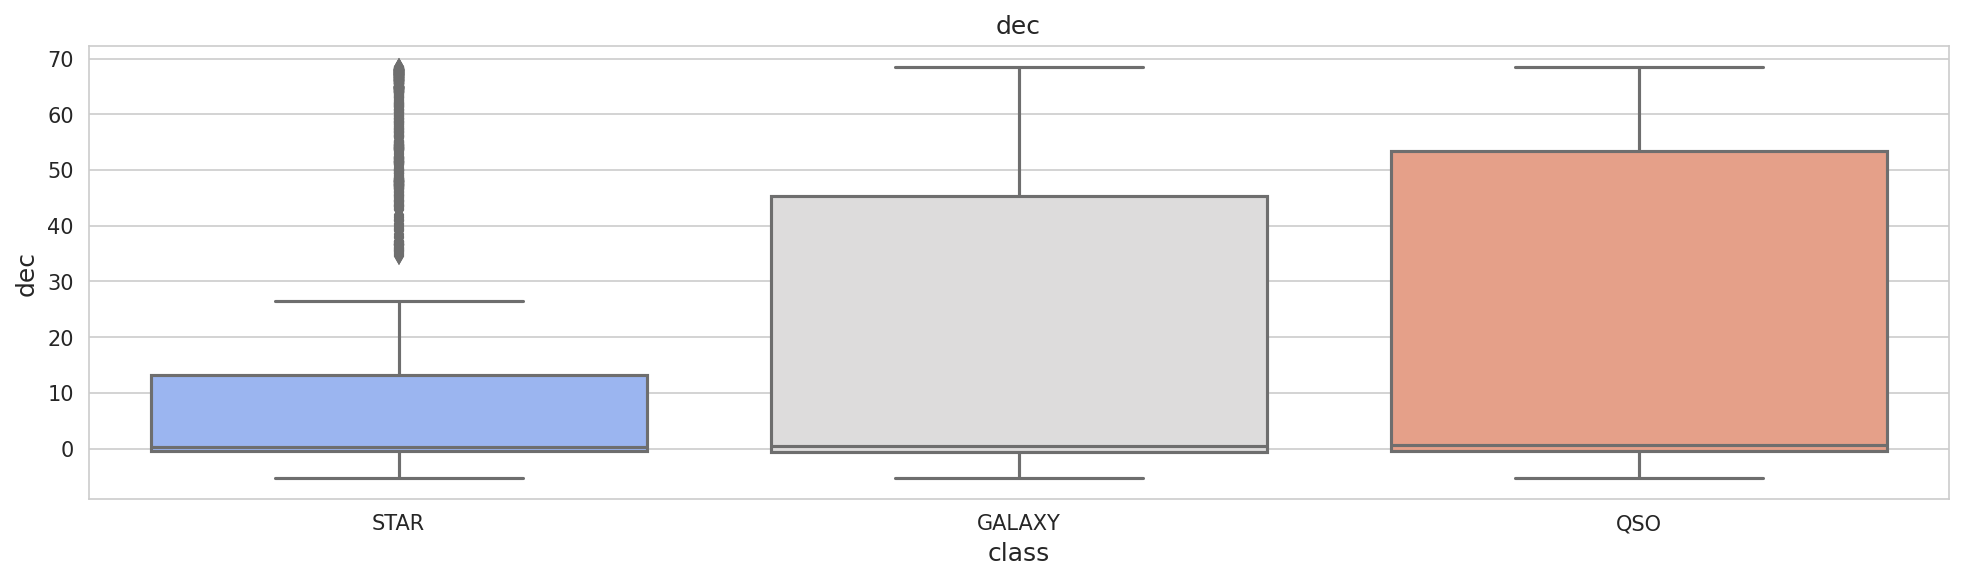

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxplot(x=sdss_df['class'], y=sdss_df['dec'], palette='coolwarm')
ax.set_title('dec')

In this case we can observe a clear distinction between Stars and the other two classes. The difference between Galaxies and Quasars is smaller.

**Star**: The largest part of the data points lay within a 0 to 10 range. Another large part consists of values between about 10 to 55. Only small amounts of the data are lower or higher than these ranges.

**Galaxy:** The largest part of values lays between 0 and 45. There is a smaller amount of values in the range of 45 to 60. The rest of the data has smaller or higher values.

**QSO**: This plot looks quite similiar to the GALAXY plot. Only the amount of data points in the range of 0 to 60 is even bigger.

**Side Note**: The fact that the distribution of dec values of galaxies und quasar objects is almost the same might indicate that one can find both galaxies and quasars at smiliar positions in the night sky.

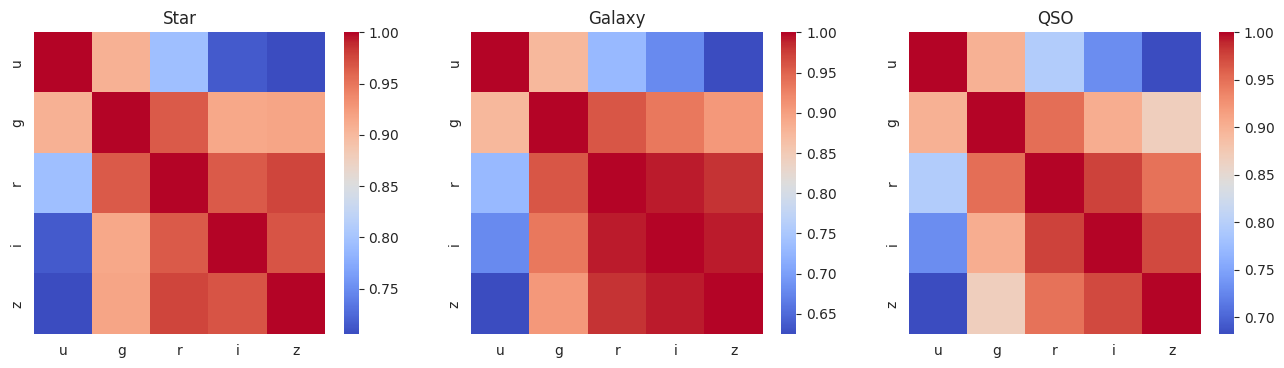

In [12]:
#Multivariate Analysis
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(sdss_df[sdss_df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(sdss_df[sdss_df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(sdss_df[sdss_df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Equatorial coordinates')

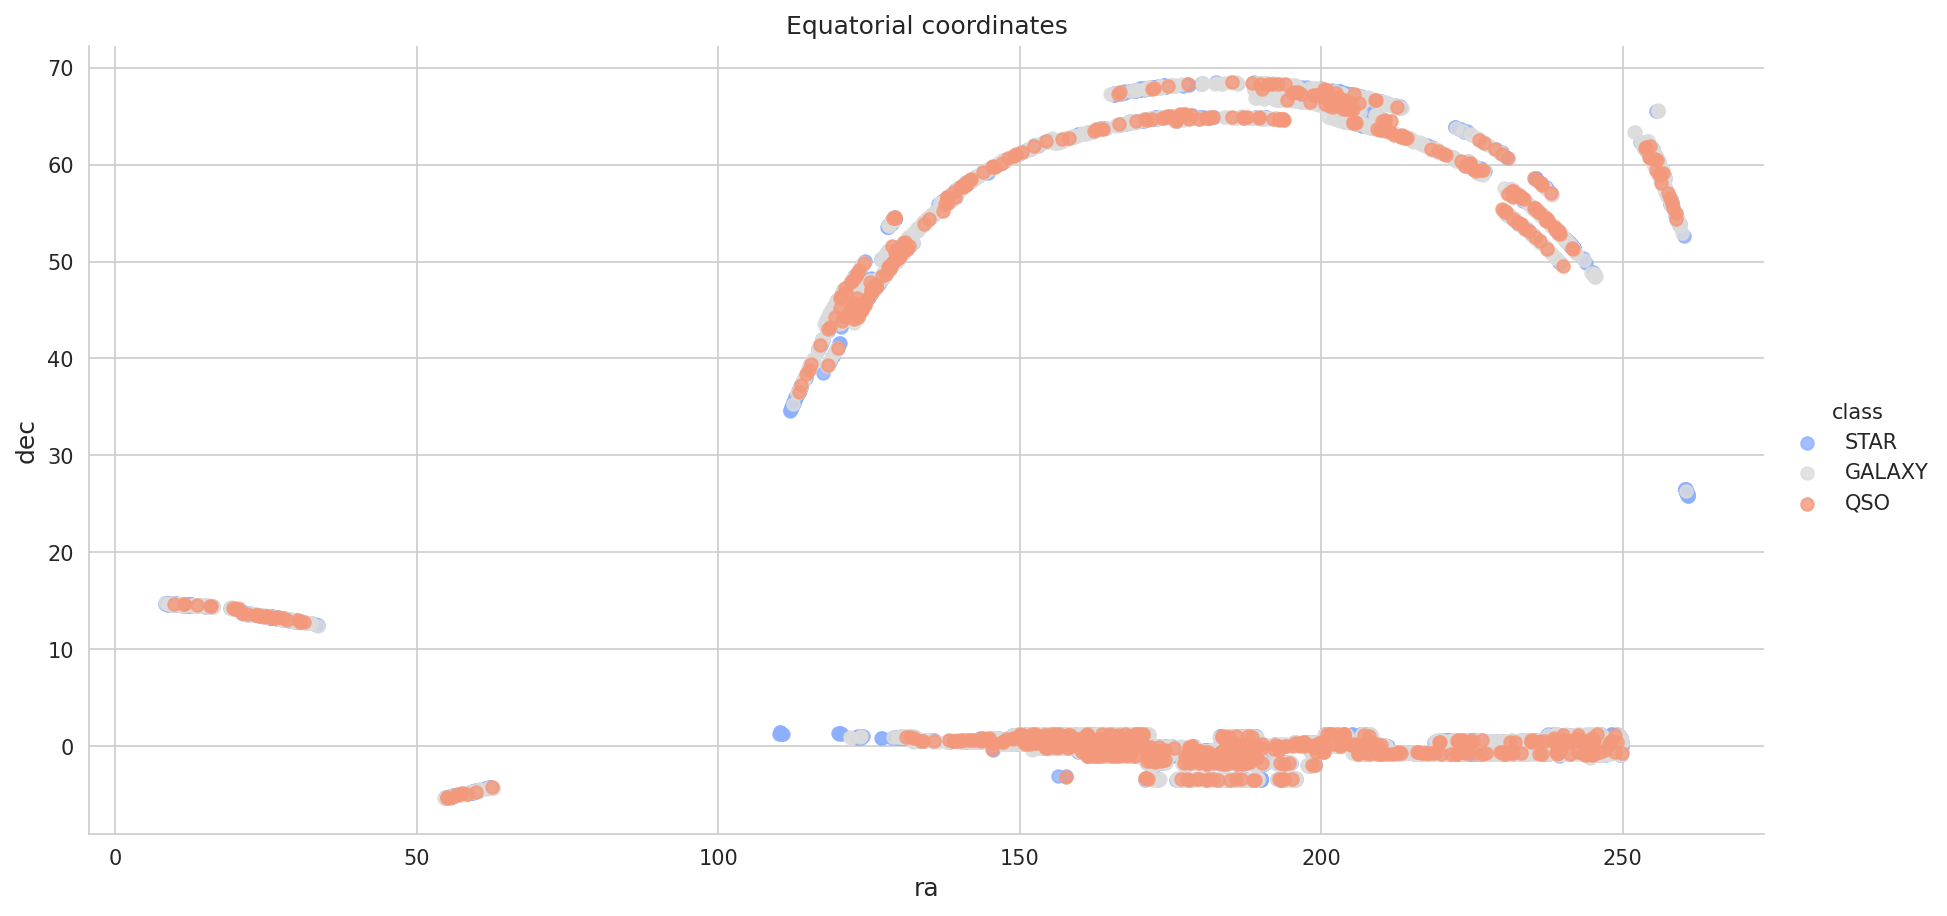

In [13]:
#Right ascension (ra) and declination (dec)
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', size=6, aspect=2)
plt.title('Equatorial coordinates')

In [16]:
#Feature Engineering
#u, g, r, i, z
#We will now reduce the amount of dimensions by replacing the different bands 'u', 'g', 'r', 'i' and 'z' by a linear combination with only 3 dimensions using Principal Component Analysis.
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598370,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


In [15]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

In [18]:
#K Nearest Neighbours
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 92.52
Time consumed for training: 0.015 seconds
Time consumed for prediction: 0.15143 seconds


In [19]:
#Naive Bayes
from sklearn.preprocessing import MaxAbsScaler
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(sdss_df_fe.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 97.88
Time consumed for training: 0.006 seconds
Time consumed for prediction: 0.00643 seconds


In [20]:
#XGBoost
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 99.21
Time consumed for training: 1.412
Time consumed for prediction: 0.02355 seconds


In [21]:
#Sckit-Learn's  Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 98.94
Time consumed for training: 0.141 seconds
Time consumed for prediction: 0.00558 seconds


In [22]:
#Support Vector Machine Classifier
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 94.09
Time consumed for training: 0.511 seconds
Time consumed for prediction: 0.29067 seconds


In [23]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Score': [acc_knn, acc_gnb, acc_xgb, acc_rfc, acc_svc],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
XGBoost,99.212121,1.412272,0.023548
Random Forest,98.939394,0.140715,0.005581
Naive Bayes,97.878788,0.005685,0.006430
SVC,94.090909,0.510637,0.290666
KNN,92.515152,0.014620,0.151426


In [24]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99552239 0.99402985 0.99402985 0.99104478 0.98955224 0.99402985
 0.99402985 0.99402985 0.99402985 0.99402985]
Mean: 0.9934328358208957
Standard Deviation: 0.0016620192127851042


In [25]:
#XGBoost
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99552239 0.99402985 0.99552239 0.99402985 0.99402985 0.99552239
 0.99552239 0.99552239 0.99552239 0.99253731]
Mean: 0.9947761194029852
Standard Deviation: 0.0010012244675372173


In [26]:
#Feature Importance
importances = pd.DataFrame({
    'Feature': sdss_df_fe.drop('class', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
redshift,0.908856
PCA_3,0.031581
PCA_2,0.012335
plate,0.009794
PCA_1,0.009027
mjd,0.008242
fiberid,0.008009
ra,0.007269
dec,0.004888


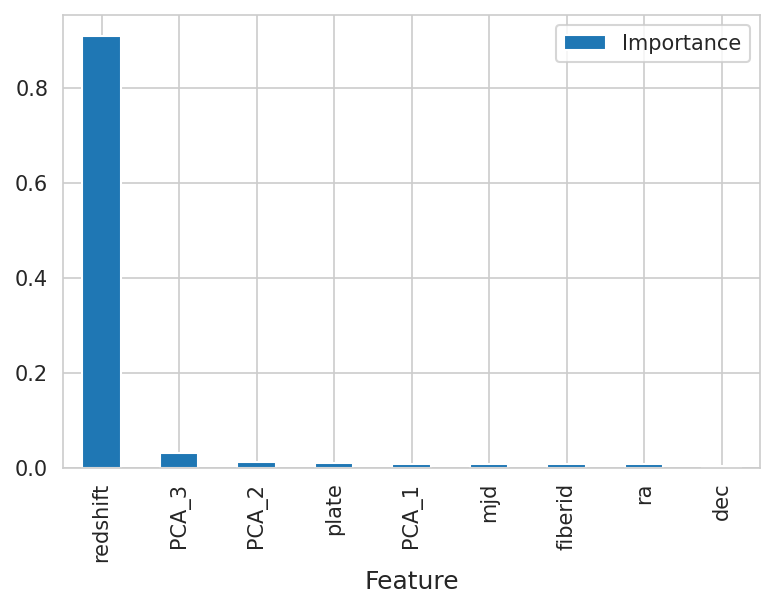

In [27]:
importances.plot.bar()

In [28]:
scaler = MinMaxScaler()
sdss = pd.DataFrame(scaler.fit_transform(sdss_df_fe.drop(['mjd', 'class'], axis=1)), columns=sdss_df_fe.drop(['mjd', 'class'], axis=1).columns)
sdss['class'] = sdss_df_fe['class']

In [29]:
sdss.head()

,ra,dec,redshift,plate,fiberid,PCA_1,PCA_2,PCA_3,class
0,0.693832,0.074025,0.000770,0.373281,0.490490,0.385886,0.069348,0.387685,2
1,0.694098,0.074642,0.000762,0.006999,0.540541,0.448110,0.215264,0.415556,2
2,0.694422,0.074519,0.023749,0.002579,0.512513,0.518964,0.154511,0.490959,0
3,0.695175,0.073487,0.000751,0.373281,0.509510,0.388785,0.279638,0.452852,2
4,0.695225,0.074199,0.000882,0.373281,0.511512,0.417103,0.357613,0.353918,2


Summary

We trained different machine learning models to solve this classification problems. Without any further hyperparameter tuning XGBoost and Scikit-Learn's Random Forest Classifier performed the best.

As XGBoost showed a little higher accuracy in most of the tests, we will continue only with this classifier.

XGBoost - Finding the best hyperparameters
Now it's time to look for the optimal hyperparameters - what does this mean?

We will test our chosen model with different values for (almost) each of its tuning parameters and give back the parameters with which the model performed best.

**The actual searching for optimal parameters is not done in this notebook since the operations can take some time and parallel editing would not be possible.

We will write our transformed data set to disk so the tuning scripts can access it.

In [ ]:
sdss.to_csv('sdss_data.csv')

In [ ]:
#XGBoost - Testing optimal hyperparameters
X_train, X_test, y_train, y_test = train_test_split(sdss.drop('class', axis=1), sdss['class'],
                                                   test_size=0.33)

In [ ]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

The parameter tuning did not improve the accuracy as excpected. We will therefore do a cross validation to test to get a more reliable result.

In [ ]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Depending on the run the cross validation results vary from a little lower and a little better than before.

This indicates that the parameter tuning was not as effective as expected - this could mean that XGBoost was actually close to its maximum performance capability on this data set.

As we still have a good performance we will now continue with further evaluation of the performance of our model!

In [ ]:
#XGBoost - Evaluation
#Confusion Matrix
unique, counts = np.unique(sdss['class'], return_counts=True)
dict(zip(unique, counts))

In [ ]:
predictions = cross_val_predict(xgb, sdss.drop('class', axis=1), sdss['class'], cv=3)
confusion_matrix(sdss['class'], predictions)

In [ ]:
print("Precision:", precision_score(sdss['class'], predictions, average='micro'))
print("Recall:",recall_score(sdss['class'], predictions, average='micro'))

In [ ]:
print("F1-Score:", f1_score(sdss['class'], predictions, average='micro'))

Summary

In this notebook learned how to get data from the SDSS RD14, analyze the data (we learned some very interesting facts about our space along the way), how to build a machine learning model to predict for unseen data from this data set and how to improve its performance (even though there was only a slight improvent). We used XGBoost for predicting and evaluated its result